# AI for Earth System Science Hackathon 2020
# GOES Challenge
David John Gagne, Gunther Wallach, Charlie Becker, Bill Petzke

## Introduction
![GOES-R satellite image from Wikipedia](goes_images/GOES-R_SPACECRAFT.jpg)

Lightning kills roughly 30 people per year in the United States (https://www.weather.gov/safety/lightning-victims) and can have large economic impacts by disrupting outdoor work and events and by sparking fires. Improved short term prediction of lightning onset can help protect life and property by ensuring that people can get to safety with sufficient lead time. The economic impacts of lightning protection practices can also be reduced by improving the prediction of when lightning is expected to end. 

Recently deployed observational systems combined with advances in machine learning have the potential to improve the short-term prediction of lightning by associating broader scale weather patterns with the future occurrence of lightning in that area. The Geostationary Operational Environmental Satellite 16 (GOES-16) is a weather satellite that orbits the Earth at a fixed point situated along the same longitude as the Eastern United States and can provide a hemispheric, multispectral view of cloud patterns at high space and time resolution through its Advanced Baseline Imager (ABI) camera. The satellite also holds the Geostationary Lightning Mapper (GLM) instrument that records lightning flashes across the hemispheric view of the satellite. By combining the data collected by these two instruments, we can develop new machine learning solutions to the challenge of short range lightning prediction.  

## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* tqdm


In [2]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 h5netcdf tqdm tensorflow scikit-learn dask s3fs goes16ci seaborn

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster, progress
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D
import s3fs
from glob import glob
%matplotlib inline

# Set random seed
seed = 3985
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Data

### Data Generation


There are several GOES-16 data products available. We are primarily interested in the water vapor bands from the Advanced Baseline Imager (ABI) and lightning counts from the Geostationary Lightning Mapper (GLM). The ABI camera’s spatial resolution is 2 km with a temporal resolution of 5 minutes. We chose to select/crop 32 x 32 sized image patches (for each band) across our domain (CONUS Midwest) at an upsampled rate of every 20 minutes from 2019-03-02 through 2019-10-01. We used these same spatio-temporal patches to aggregate all lightning flash counts within that patch but lagged by one hour. Total aggregated data was output at a daily interval.  

### Useful Links

[Overall GOES-16 Band Reference Guide](https://www.weather.gov/media/crp/GOES_16_Guides_FINALBIS.pdf)

[GOES-16 Band 08 Info (Upper-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band08.pdf)

[GOES-16 Band 09 Info (Mid-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band09.pdf)

[GOES-16 Band 10 Info (Low-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band10.pdf)

[GOES-16 Band 14 Info (Longwave Window)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band14.pdf)

[GOES-16 Geostationary Lightning Mapper (GLM)](https://www.goes-r.gov/spacesegment/glm.html)


### Time span of the dataset

|  | Date/Time | 
| ------------- | :---- |
| Start | 2019-03-02 00:20:00 | 
| End | 2019-10-02 00:00:00 |
| Timestep | 00:20:00 | 
| NOTE: some days are missing (intentionally skipped) to isolate convective cycles





### Geographic Coverage of Dataset (Mostly Midwest CONUS)

|  | Latitude | Longitude |
| ------------- | :----:|:- |
| Min | 29.09 | -97.77 |
| Max | 48.97 | -82.53 |




### Dimensions

| Dimension Name | Description | Size |
| ------------- | :----:|:----------- |
| Band     | ABI Band Number  | 4 (Bands 8,9,10,14) |
| Patch      | spatio-temporal patch | ~3600 per day |
| X      | X-plane | 32 |
| Y      | Y-plane | 32 |

### Potential Input Variables

| Variable Name | Units | Description | 
| ------------- | :----:|:----------- | 
| abi (Band 08)   | K     | Upper-level Water Vapor | 
| abi (Band 09)   | K     | Mid-level Water Vapor   |
| abi (Band 10)   | K     | Lower-level Water Vapor |
| abi (Band 14)   | K     | Longwave Window         |

### Output Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| flash_counts    | -     | Lightning strike count |


### Metadata Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| Time     | YYYY-MM-DDTHH:MM:SS  | The Date   |
| Lat      | Degrees     | Latitude   |
| Lon      | Degrees     | Longitude  |


### Training/Validation/Testing Sets

The function `split_data_files()` will split the data files into approximately equal partitions for training/validation/testing. By default, it takes 4-day contiguous data “chunks” per partition while skipping 1 day between to isolate convective cycles (and thus not validate/test on data linked to the training data), and repeats throughout the selected timespan.  Thus, each set should contain approximately 210,000 (32 x 32)  samples (patches) if the entire timespan is used.


In [4]:
# How to load the data from disk or cloud

def split_data_files(dir_path="ncar-aiml-data-commons/goes/ABI_patches_32/", file_prefix='abi_patches_', 
               start_date='20190302', end_date='20191001', seq_len=4, skip_len=1):
    """
    Take daily ABI patch files and split into equal training/validation/testing
    semi-contiguous partitions, skipping day(s) between chunks to isolate convective 
    cycles.
    
    Args: 
        dir_path: (str) Directory path to daily ABI files
        file_prefix: (str) File prefix up to date 
        start_date: (str) Starting date to get files in format of YYYYMMDD
        end_date: (str) Ending date to get files in format of YYYYMMDD
        seq_len: (int) Length of days per 'chunk' of data
        skip_len: (int) How many days to skip between data chunks
        
    Returns:
        train_f, val_f, test_f: list of training/validation/test files
    """
    
    all_files = fs.ls(dir_path)
    start_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, start_date))
    end_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, end_date))
    file_spread = all_files[start_index:end_index+1]
    
    train_files, val_files, test_files = [], [], []
    
    for i in np.arange(0, len(file_spread)+1, (seq_len+skip_len)*3):
        
        val_i = i + seq_len + skip_len
        test_i = i + (seq_len + skip_len)*2
        
        train_files.append(file_spread[i:i+seq_len])
        val_files.append(file_spread[val_i:val_i+seq_len])
        test_files.append(file_spread[test_i:test_i+seq_len])
        
    train_f = [item for sublist in train_files for item in sublist]
    val_f = [item for sublist in val_files for item in sublist]
    test_f = [item for sublist in test_files for item in sublist]
    
    return train_f, val_f, test_f

def fetch_data(file_number, file_list):
    """
    Function to be distributed across a cluster to individually load files directly from an AWS S3 bucket 
    
    Args:
        file_number: index for file from file_list
        file_list: List of files to index from
    Returns:
        ds: xarray dataset of daily file 
    """
    obj = fs.open(file_list[file_number])
    ds = xr.open_dataset(obj, chunks={})
    
    return ds

def merge_data(file_list):
    """
    Take a list of files and distribute across a cluster to be loaded then gathered and concantenated
    
    Args:
        file_list: List of files to be merged together (training, validation, or testing)
    Returns:
        merged_data: Concatenated xarray dataset of training, validation, or testing data 
    """
    futures = client.map(fetch_data, range(len(file_list)), [file_list]*len(file_list))
    results = client.gather(futures)
    merged_data = xr.concat(results, 'patch').compute()
    
    return merged_data

def prepare_data(data):
    """
    Take GOES netCDF data, filter out NaNs, reshape for tensorflow, convert flash_counts to binary,
    and return filtered numpy arrays
    Args:
        data: GOES patch netCDF data including ABI bands and lightning flash counts
    Returns:
        good_imagery: NaN filtered numpy array with reshaped dimensions (patch, x, y, band)
        binary_output: 1D numpy array of lightnin flash_counts
    """
    
    input_data = np.moveaxis(data['abi'].values, 1, -1)
    output_data = data['flash_counts'].values
    
    nan_indices = np.unique(np.where(np.isnan(input_data))[0])
    all_indices = np.arange(input_data.shape[0])
    valid_indices = all_indices[np.isin(all_indices, nan_indices, assume_unique=True, invert=True)]
    
    good_imagery = input_data[valid_indices]
    binary_output = np.where(output_data > 0, 1, 0)[valid_indices]
    
    return good_imagery, binary_output

We use DASK to create a local cluster to speed up the data loading process (Loading data directly from an AWS S3 bucket can be slow).

In [5]:
cluster = LocalCluster(processes=True, threads_per_worker=2)
client = Client(cluster)
fs = s3fs.S3FileSystem(anon=True)

In [6]:
%%time
# Split into training, validation, and test sets
# We only load the train and val sets here to save a couple minutes
train_files, val_files, test_files = split_data_files()
train, val = map(merge_data, [train_files, val_files])

CPU times: user 26 s, sys: 44.6 s, total: 1min 10s
Wall time: 4min 58s


In [7]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


# run till here


## Exploratory visualizations

##When seperating by band, lightning active patches usually have a similar brightness temperature (BT) profiles throughout the 4 water vapor channels. Low BT convective cells are often seen as well (as expected).

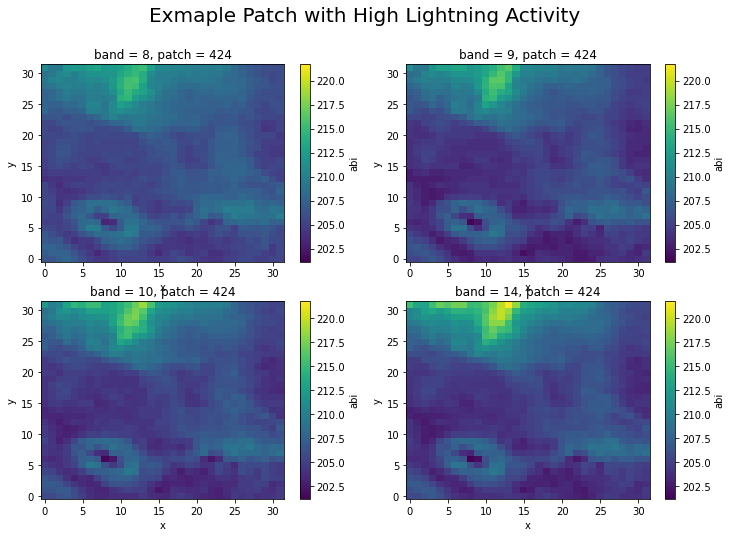

In [7]:
high_lc_indices = np.argwhere(train.flash_counts.values > 100).flatten() # indices with more than 100 lightning counts
no_lc_indices = np.argwhere(train.flash_counts.values == 0).flatten() # indices with no lightning counts

index = high_lc_indices[205]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range  
vmax = train['abi'][index,:,:,:].max()

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch with High Lightning Activity', fontsize=20)

Areas without lightning activity often exibit a much larger BT range throughout the channel column, particularily the longwave window (Band 14) which often has much higher values with clear skies.

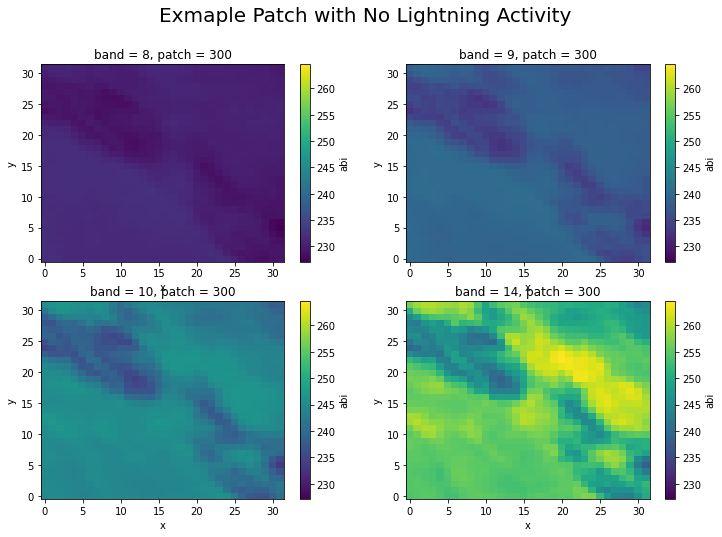

In [8]:
index = no_lc_indices[300]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range
vmax = train['abi'][index,:,:,:].max() # set min/max plotting range

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch with No Lightning Activity', fontsize=20)

This pattern is also noted when taking the mean value of each patch across the dataset.

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


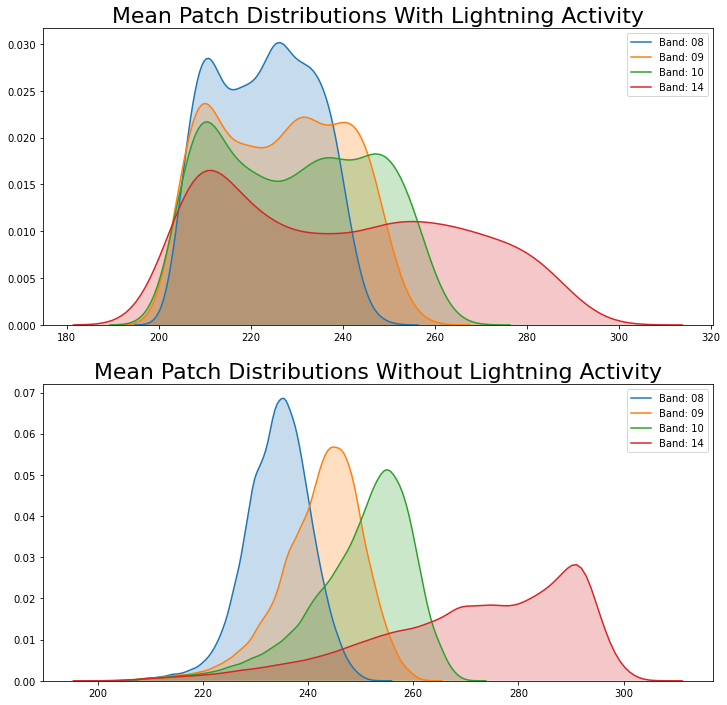

In [9]:
lc_train = train.isel(patch=high_lc_indices) # all patch data with lightning counts (above threshold)
no_lc_train = train.isel(patch=no_lc_indices) # all patch data without lightning activity
mean_patches_lc = lc_train.abi.mean(dim=('x','y')) # mean BT of each patch
mean_patches_no_lc = no_lc_train.abi.mean(dim=('x','y')) # mean BT of each patch

fig, ax = plt.subplots(2,1, figsize=(12,12))
for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):
    if i < 4:
        sns.kdeplot(mean_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
            'Mean Patch Distributions With Lightning Activity', fontsize=22)
    else:
        sns.kdeplot(mean_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
            'Mean Patch Distributions Without Lightning Activity', fontsize=22)

### Data Transforms
Discuss any transforms or normalizations that may be needed for this dataset. Remember to fit a scaler only to the training data and then apply it on testing and validation.

In [10]:
# Visual of input variable before and after transform
# Example of data transform procedure for dataset

In [11]:
%%time
# get numpy arrays of patch data for each band (this also converts all flash_counts to binary classes)
train_in, train_out = prepare_data(train) 
val_in, val_out = prepare_data(val)

# scale data
scaler = MinMaxScaler2D()
scaled_train_in = scaler.fit_transform(train_in)
scaled_val_in = scaler.transform(val_in)

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


CPU times: user 21.7 s, sys: 7.5 s, total: 29.2 s
Wall time: 28.9 s


In [12]:
# declare ResNet (residual network from the goes16i module) and list the default parameters
# Any of these parameters can be overridden
# note using larger batch sizes here can cause memory errors
resNet_mod = ResNet(epochs=5, batch_size=512)
vars(resNet_mod)

{'min_filters': 16,
 'filter_width': 3,
 'filter_growth_rate': 2,
 'min_data_width': 4,
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid',
 'use_dropout': False,
 'pooling': 'mean',
 'dropout_alpha': 0.0,
 'data_format': 'channels_last',
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'loss': 'mse',
 'metrics': None,
 'leaky_alpha': 0.1,
 'batch_size': 512,
 'epochs': 5,
 'sgd_momentum': 0.99,
 'model': None,
 'parallel_model': None,
 'time_history': <goes16ci.models.TimeHistory at 0x7f1e21b8b290>,
 'loss_history': <goes16ci.models.LossHistory at 0x7f1e21750190>,
 'verbose': 0}

In [13]:
%%time
# Fit model and print architecture
resNet_mod.fit(scaled_train_in, train_out, scaled_val_in, val_out)
resNet_mod.model.summary()

{'loss': 0.08095646649599075, 'val_loss': 0.2931648790836334}
{'loss': 0.06789491325616837, 'val_loss': 0.08812424540519714}
{'loss': 0.06436078250408173, 'val_loss': 0.09999733418226242}
{'loss': 0.06302028894424438, 'val_loss': 0.11229163408279419}
{'loss': 0.06096876785159111, 'val_loss': 0.11667578667402267}
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          [(None, 32, 32, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   592         scn_input[0][0]                  
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 32, 32, 16)   64          conv2d[0][0]

## Baseline ResNet Evaluation Metrics
We trained on binary output data, but output probabilities before converting to class. This allows us to evaluate regressed and classified metrics:


| Type | Metric | Value to beat |
| ------------- | :----:|:-------|
|  Regressed   ||   
|              | RMSE: |0.328|
|              | R2: |0.567 |
|              | Hellenger Distance: |0.501|
|||
| Classified   |||
|              | Heidke Skill Score: |0.705|
|              | Peirce Skill Score:  |0.713|
|              | Brier Score: |0.143|
|              | Brier Skill Score: |0.402|
|              | AUC: |0.856|

In [14]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = resNet_mod.predict(scaled_val_in).reshape(val_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [14]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

In [16]:
# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

RMSE: 0.342
R squared: 0.542
Hellenger Distance: 0.564
Heidke Skill Score: 0.677
Pierce Skill Score: 0.696
Brier Score: 0.159
Brier Skill Score: 0.337
AUC: 0.848


## Interpretation
Description of interpretation methods for problem

In [17]:
# Include examples of interpretation code

## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

In [17]:
# Monday's code goes here

# From YiFei Guan
# Load data
cluster = LocalCluster(processes=True, threads_per_worker=2)
client = Client(cluster)
fs = s3fs.S3FileSystem(anon=True)

# Split into training, validation, and test sets
# We only load the train and val sets here to save a couple minutes
train_files, val_files, test_files = split_data_files()
train, val = map(merge_data, [train_files, val_files])
client.shutdown()

/opt/conda/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45747 instead
  http_address["port"], self.http_server.port
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


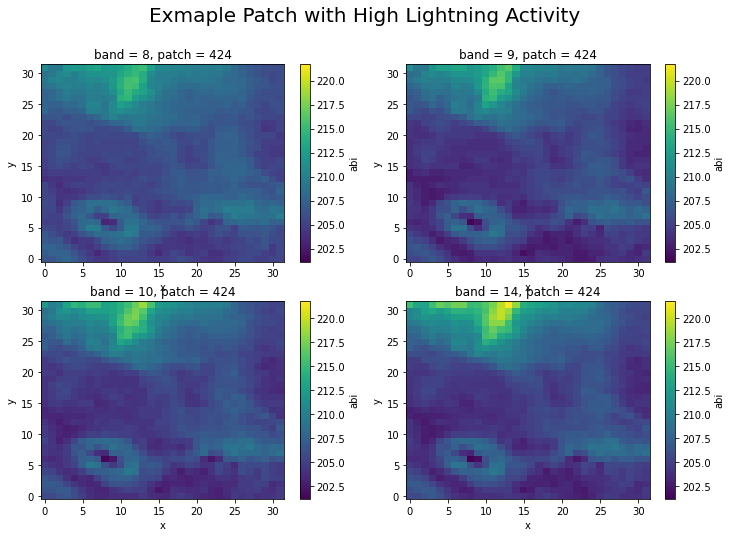

In [18]:
# Exploratory visualization of the data
high_lc_indices = np.argwhere(train.flash_counts.values > 100).flatten() # indices with more than 100 lightning counts
no_lc_indices = np.argwhere(train.flash_counts.values == 0).flatten() # indices with no lightning counts

index = high_lc_indices[205]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range  
vmax = train['abi'][index,:,:,:].max()

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch with High Lightning Activity', fontsize=20)

In [19]:
# Test 2 different transformations and scaling methods
# get numpy arrays of patch data for each band (this also converts all flash_counts to binary classes)
train_in, train_out = prepare_data(train) 
val_in, val_out = prepare_data(val)

# scale data
# 1st transformation and scaling methods
scaler = MinMaxScaler2D()
scaled_train_in = scaler.fit_transform(train_in)
scaled_val_in = scaler.transform(val_in)

 # 2nd transformation and scaling methods
scaled_train_in = (train_in - np.mean(train_in.flatten()))/np.std(train_in.flatten())
scaled_val_in = (val_in - np.mean(val_in.flatten()))/np.std(val_in.flatten())

In [20]:
n_times = np.shape(train_in[:,:,:,0])
print(n_times)

(212604, 32, 32)


In [21]:
from sklearn.preprocessing import MinMaxScaler
n_channels = 4
nt_times = np.shape(train_in)[0]
nv_times = np.shape(val_in)[0]

scaled_train_in = np.zeros_like(train_in)
scaled_val_in = np.zeros_like(val_in)

channel_scalers = []

for i in range(n_channels):
    mmx = MinMaxScaler()
    slc = train_in[:, :, :, i].reshape(n_times, 32*32) # make it a bunch of row vectors
    transformed = mmx.fit_transform(slc)
    transformed = transformed.reshape(n_times, 32, 32) # reshape it back to tiles
    scaled_train_in[:, :, :, i] = transformed # put it in the transformed array
    
    slc = val_in[:, :, :, i].reshape(nv_times, 32*32) # make it a bunch of row vectors
    transformed = mmx.fit_transform(slc)
    transformed = transformed.reshape(nv_times, 32, 32) # reshape it back to tiles
    scaled_val_in[:, :, :, i] = transformed # put it in the transformed array

TypeError: 'tuple' object cannot be interpreted as an integer

In [30]:
# Dimensionality reduction via PCA
from sklearn.decomposition import PCA
n_channels = 4
nt_times = np.shape(train_in)[0]
nv_times = np.shape(val_in)[0]

X_train_pca = np.zeros([nt_times, 2, 2, n_channels])
X_val_pca = np.zeros([nv_times, 2, 2, n_channels])

for i in range(n_channels):
    pca = PCA(n_components = 4)
    slc = scaled_train_in[:, :, :, i].reshape(nt_times, 32*32) # make it a bunch of row vectors
    slc.shape
    transformed = pca.fit_transform(slc)
    transformed = transformed.reshape(nt_times, 2, 2) # reshape it back to tiles
    X_train_pca[:, :, :, i] = transformed # put it in the transformed array
    
    pca = PCA(n_components = 4)
    slc = scaled_val_in[:, :, :, i].reshape(nv_times, 32*32) # make it a bunch of row vectors
    transformed = pca.fit_transform(slc)
    transformed = transformed.reshape(nv_times, 2, 2) # reshape it back to tiles
    X_val_pca[:, :, :, i] = transformed # put it in the transformed array


/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_pca.py:555: RuntimeWarning: invalid value encountered in t

In [ ]:
# Train a linear model
from sklearn.linear_model import LogisticRegression
n_channels = 4
n_components = 4
nt_times = np.shape(train_in)[0]
lr = LogisticRegression()
lr.fit(X_train_pca[:,:,:,0].reshape(nt_times,n_components), train_out)

In [ ]:
# Train a decision tree ensemble method of your choice
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 4, random_state = 1)
tree.fit(X_train_pca[:,:,:,0].reshape(nt_times,n_components), train_out)

### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

In [2]:
# Tuesday's code goes here
# CNN

In [1]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 h5netcdf tqdm tensorflow scikit-learn dask s3fs goes16ci seaborn

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster, progress
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D
import s3fs
from glob import glob
%matplotlib inline

# Set random seed
seed = 3985
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
# How to load the data from disk or cloud

def split_data_files(dir_path="ncar-aiml-data-commons/goes/ABI_patches_32/", file_prefix='abi_patches_', 
               start_date='20190302', end_date='20191001', seq_len=4, skip_len=1):
    """
    Take daily ABI patch files and split into equal training/validation/testing
    semi-contiguous partitions, skipping day(s) between chunks to isolate convective 
    cycles.
    
    Args: 
        dir_path: (str) Directory path to daily ABI files
        file_prefix: (str) File prefix up to date 
        start_date: (str) Starting date to get files in format of YYYYMMDD
        end_date: (str) Ending date to get files in format of YYYYMMDD
        seq_len: (int) Length of days per 'chunk' of data
        skip_len: (int) How many days to skip between data chunks
        
    Returns:
        train_f, val_f, test_f: list of training/validation/test files
    """
    
    all_files = fs.ls(dir_path)
    start_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, start_date))
    end_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, end_date))
    file_spread = all_files[start_index:end_index+1]
    
    train_files, val_files, test_files = [], [], []
    
    for i in np.arange(0, len(file_spread)+1, (seq_len+skip_len)*3):
        
        val_i = i + seq_len + skip_len
        test_i = i + (seq_len + skip_len)*2
        
        train_files.append(file_spread[i:i+seq_len])
        val_files.append(file_spread[val_i:val_i+seq_len])
        test_files.append(file_spread[test_i:test_i+seq_len])
        
    train_f = [item for sublist in train_files for item in sublist]
    val_f = [item for sublist in val_files for item in sublist]
    test_f = [item for sublist in test_files for item in sublist]
    
    return train_f, val_f, test_f

def fetch_data(file_number, file_list):
    """
    Function to be distributed across a cluster to individually load files directly from an AWS S3 bucket 
    
    Args:
        file_number: index for file from file_list
        file_list: List of files to index from
    Returns:
        ds: xarray dataset of daily file 
    """
    obj = fs.open(file_list[file_number])
    ds = xr.open_dataset(obj, chunks={})
    
    return ds

def merge_data(file_list):
    """
    Take a list of files and distribute across a cluster to be loaded then gathered and concantenated
    
    Args:
        file_list: List of files to be merged together (training, validation, or testing)
    Returns:
        merged_data: Concatenated xarray dataset of training, validation, or testing data 
    """
    futures = client.map(fetch_data, range(len(file_list)), [file_list]*len(file_list))
    results = client.gather(futures)
    merged_data = xr.concat(results, 'patch').compute()
    
    return merged_data

def prepare_data(data):
    """
    Take GOES netCDF data, filter out NaNs, reshape for tensorflow, convert flash_counts to binary,
    and return filtered numpy arrays
    Args:
        data: GOES patch netCDF data including ABI bands and lightning flash counts
    Returns:
        good_imagery: NaN filtered numpy array with reshaped dimensions (patch, x, y, band)
        binary_output: 1D numpy array of lightnin flash_counts
    """
    
    input_data = np.moveaxis(data['abi'].values, 1, -1)
    output_data = data['flash_counts'].values
    
    nan_indices = np.unique(np.where(np.isnan(input_data))[0])
    all_indices = np.arange(input_data.shape[0])
    valid_indices = all_indices[np.isin(all_indices, nan_indices, assume_unique=True, invert=True)]
    
    good_imagery = input_data[valid_indices]
    binary_output = np.where(output_data > 0, 1, 0)[valid_indices]
    
    return good_imagery, binary_output

In [5]:
cluster = LocalCluster(processes=True, threads_per_worker=2)
client = Client(cluster)
fs = s3fs.S3FileSystem(anon=True)

In [6]:
%%time
# Split into training, validation, and test sets
# We only load the train and val sets here to save a couple minutes
train_files, val_files, test_files = split_data_files()
train, val = map(merge_data, [train_files, val_files])

CPU times: user 24.1 s, sys: 34.8 s, total: 58.8 s
Wall time: 4min 58s


In [7]:
client.shutdown()

In [8]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

In [10]:
%%time
# get numpy arrays of patch data for each band (this also converts all flash_counts to binary classes)
train_in, train_out = prepare_data(train) 
val_in, val_out = prepare_data(val)

# scale data
scaler = MinMaxScaler2D()
scaled_train_in = scaler.fit_transform(train_in)
scaled_val_in = scaler.transform(val_in)

# Convert the labels to one-hot vectors
print(train_out[0:5])
train_out = tf.keras.utils.to_categorical(train_out, 2)  # 2 classes
val_out = tf.keras.utils.to_categorical(val_out, 2)
print(train_out[0:5])

[0 0 0 0 0]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
CPU times: user 16.9 s, sys: 6.16 s, total: 23.1 s
Wall time: 22.9 s


Start to build a CNN model

In [11]:
def create_model():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(32,32,4))) 
  model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

  model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

  #model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
  #model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256, activation='relu')) 
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(2, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
  
  return model

In [12]:
# create the model 

model = create_model()

In [13]:
# Take a look at the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        2368      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [14]:
n_iteration = 10
#was 10
#model.fit(x_train, y_train, batch_size=64, epochs=n_iteration, shuffle=True)
history = model.fit(scaled_train_in, train_out, batch_size=64, epochs=n_iteration, shuffle=True)
print(history.history)
all_loss = history.history['loss']

Epoch 1/10
3322/3322 [==============================] - 61s 18ms/step - loss: 0.2994 - accuracy: 0.8787
Epoch 2/10
3322/3322 [==============================] - 26s 8ms/step - loss: 0.2509 - accuracy: 0.9010
Epoch 3/10
3322/3322 [==============================] - 26s 8ms/step - loss: 0.2413 - accuracy: 0.9050
Epoch 4/10
3322/3322 [==============================] - 26s 8ms/step - loss: 0.2358 - accuracy: 0.9074
Epoch 5/10
3322/3322 [==============================] - 25s 8ms/step - loss: 0.2316 - accuracy: 0.9088
Epoch 6/10
3322/3322 [==============================] - 25s 8ms/step - loss: 0.2301 - accuracy: 0.9098
Epoch 7/10
3322/3322 [==============================] - 25s 8ms/step - loss: 0.2266 - accuracy: 0.9112
Epoch 8/10
3322/3322 [==============================] - 25s 8ms/step - loss: 0.2243 - accuracy: 0.9126
Epoch 9/10
3322/3322 [==============================] - 26s 8ms/step - loss: 0.2216 - accuracy: 0.9136
Epoch 10/10
3322/3322 [==============================] - 26s 8ms/step - 

In [15]:
test_loss, test_acc = model.evaluate(scaled_val_in, val_out)
print('Test accuracy: %f' %test_acc)

6232/6232 [==============================] - 43s 7ms/step - loss: 0.2518 - accuracy: 0.8975
Test accuracy: 0.897497


In [16]:
val_in, val_out = prepare_data(val)
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = model.predict(scaled_val_in) #.reshape(val_out.shape[0])
binary_preds = np.zeros(preds.shape[0])
preds_1=preds[:,1]
binary_preds = np.where(preds_1 >= binary_threshold, 1, 0)

In [17]:
# Example regressed metrics
# print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
# print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
# print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

Heidke Skill Score: 0.788
Pierce Skill Score: 0.797
Brier Score: 0.103
Brier Skill Score: 0.571
AUC: 0.898


-------------

build an F-C NN model


In [26]:
%%time
# get numpy arrays of patch data for each band (this also converts all flash_counts to binary classes)
train_in, train_out = prepare_data(train) 
val_in, val_out = prepare_data(val)

# scale data
scaler = MinMaxScaler2D()
scaled_train_in = scaler.fit_transform(train_in)
scaled_val_in = scaler.transform(val_in)

# Convert the labels to one-hot vectors
print(train_out[0:5])
train_out = tf.keras.utils.to_categorical(train_out, 2)  # 2 classes
val_out = tf.keras.utils.to_categorical(val_out, 2)
print(train_out[0:5])

[0 0 0 0 0]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
CPU times: user 17 s, sys: 6.15 s, total: 23.2 s
Wall time: 23 s


In [27]:
def create_model2():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(32,32,4)))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    #model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(2))
    return model

In [28]:
model2 = create_model2()
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               1048832   
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
Total params: 1,090,114
Trainable params: 1,090,114
Non-trainable params: 0
____________________________________________

In [29]:
model2.compile(optimizer='adam', 
              loss=tf.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
n_iteration = 10
history2 = model2.fit(scaled_train_in, train_out, batch_size=64, epochs=n_iteration, shuffle=True)
print(history2.history)
all_loss2 = history2.history['loss']

Epoch 1/10
3322/3322 [==============================] - 14s 4ms/step - loss: 0.4646 - accuracy: 0.8035
Epoch 2/10
3322/3322 [==============================] - 14s 4ms/step - loss: 0.4084 - accuracy: 0.8324
Epoch 3/10
3322/3322 [==============================] - 14s 4ms/step - loss: 0.3892 - accuracy: 0.8406
Epoch 4/10
3322/3322 [==============================] - 14s 4ms/step - loss: 0.3781 - accuracy: 0.8448
Epoch 5/10
3322/3322 [==============================] - 14s 4ms/step - loss: 0.3703 - accuracy: 0.8489
Epoch 6/10
3322/3322 [==============================] - 14s 4ms/step - loss: 0.3661 - accuracy: 0.8506
Epoch 7/10
3322/3322 [==============================] - 14s 4ms/step - loss: 0.3632 - accuracy: 0.8515
Epoch 8/10
3322/3322 [==============================] - 14s 4ms/step - loss: 0.3612 - accuracy: 0.8518
Epoch 9/10
3322/3322 [==============================] - 14s 4ms/step - loss: 0.3589 - accuracy: 0.8531
Epoch 10/10
3322/3322 [==============================] - 14s 4ms/step - l

In [31]:
test_loss2, test_acc2 = model2.evaluate(scaled_val_in, val_out)
print('Test accuracy: %f' %test_acc2)

6232/6232 [==============================] - 17s 3ms/step - loss: 0.3878 - accuracy: 0.8424
Test accuracy: 0.842371


In [34]:
val_in, val_out = prepare_data(val)
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = model2.predict(scaled_val_in) #.reshape(val_out.shape[0])
binary_preds = np.zeros(preds.shape[0])
preds_1=preds[:,1]
binary_preds = np.where(preds_1 >= binary_threshold, 1, 0)

In [35]:
# Example regressed metrics
# print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
# print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
# print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

Heidke Skill Score: 0.0
Pierce Skill Score: 0.0
Brier Score: 0.395
Brier Skill Score: -0.653
AUC: 0.5


-------------
Another CNN model
This part of the code was developed by K. Searight

In [36]:
%%time
# get numpy arrays of patch data for each band (this also converts all flash_counts to binary classes)
train_in, train_out = prepare_data(train) 
val_in, val_out = prepare_data(val)

# scale data
scaler = MinMaxScaler2D()
scaled_train_in = scaler.fit_transform(train_in)
scaled_val_in = scaler.transform(val_in)

CPU times: user 17.1 s, sys: 5.93 s, total: 23 s
Wall time: 22.9 s


In [37]:
nt_times = np.shape(scaled_train_in[:,:,:,0])
print(nt_times)
nv_times = np.shape(scaled_val_in[:,:,:,0])
print(nv_times)

(212604, 32, 32)
(199399, 32, 32)


In [38]:
# CNN
cnn = StandardConvNet(epochs=5)
vars(cnn)

{'min_filters': 16,
 'filter_width': 5,
 'filter_growth_rate': 2,
 'min_data_width': 4,
 'hidden_activation': 'relu',
 'output_activation': 'sigmoid',
 'use_dropout': False,
 'pooling': 'mean',
 'dropout_alpha': 0.0,
 'data_format': 'channels_last',
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'loss': 'mse',
 'metrics': None,
 'leaky_alpha': 0.1,
 'batch_size': 1024,
 'epochs': 5,
 'sgd_momentum': 0.99,
 'model': None,
 'parallel_model': None,
 'time_history': <goes16ci.models.TimeHistory at 0x7f09483c4410>,
 'loss_history': <goes16ci.models.LossHistory at 0x7f09483c4190>,
 'verbose': 0}

In [ ]:
%%time
# Fit model and print architecture
cnn.fit(scaled_train_in, train_out, scaled_val_in, val_out)
cnn.model.summary()

{'loss': 0.13472598791122437, 'val_loss': 0.11272187530994415}
{'loss': 0.1074197068810463, 'val_loss': 0.10887259244918823}
{'loss': 0.10015366971492767, 'val_loss': 0.10080493241548538}


In [19]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = model2.predict(scaled_val_in).reshape(val_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [15]:
# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

RMSE: 0.312
R squared: 0.603
Hellenger Distance: 0.625
Heidke Skill Score: 0.737
Pierce Skill Score: 0.736
Brier Score: 0.126
Brier Skill Score: 0.473
AUC: 0.868


### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

In [20]:
# Wednesday's code goes here
# Code is updated in the Tuesday section


### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

In [1]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 h5netcdf tqdm tensorflow scikit-learn dask s3fs goes16ci seaborn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster, progress
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D
import s3fs
from glob import glob
%matplotlib inline

# Set random seed
seed = 3985
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# Thursday's code goes here

# 2-layer ANN
all_accuracy_1=np.array( [0.8034703135490417, 0.8324161171913147, 0.8406097888946533, 
                        0.8448382616043091, 0.8488833904266357, 0.8505531549453735, 
                        0.8514515161514282, 0.851823091506958, 0.853107213973999, 0.8540478944778442])

all_loss_1=np.array( [0.4645897150039673, 0.40840134024620056, 0.3891577422618866, 
                      0.37814822793006897, 0.3702731132507324, 0.36609315872192383, 
                      0.3632112443447113, 0.36122000217437744, 0.3588770031929016, 0.3561069667339325])

# 2-layer CNN
all_accuracy_2=np.array( [0.8729798197746277, 0.893957793712616, 0.8988118767738342, 
                        0.9013612270355225, 0.9047948122024536, 0.9056462049484253, 
                        0.9074711799621582, 0.9086846709251404, 0.9098699688911438, 0.9115726947784424])


all_loss_2=np.array( [0.3157445788383484, 0.2662068009376526, 0.255046546459198, 
                      0.24804221093654633, 0.24226537346839905, 0.2389853596687317, 
                      0.23506499826908112, 0.2324257344007492, 0.22975461184978485, 0.22690463066101074])

# 3-layer CNN
all_accuracy_3=np.array( [0.8787322640419006, 0.9009849429130554, 0.9049641489982605, 
                        0.9073582887649536, 0.908797562122345, 0.9097759127616882, 
                        0.9112246036529541, 0.9126356840133667, 0.9135622978210449, 0.9148463606834412])

all_loss_3=np.array( [0.29935523867607117, 0.25088709592819214, 0.24128125607967377, 
                      0.23575809597969055, 0.2316075712442398, 0.23006828129291534, 
                      0.22655485570430756, 0.2242521345615387, 0.22160455584526062, 0.21971799433231354])



xaxis=range(1,11)


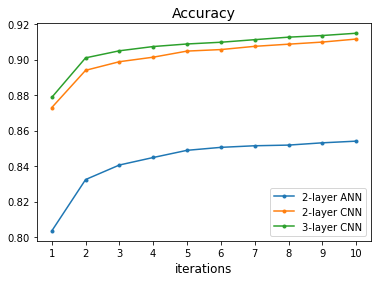

In [4]:
plt.plot(xaxis, all_accuracy_1, '.-', xaxis, all_accuracy_2, '.-',  xaxis, all_accuracy_3, '.-') #2ANN, 2CNN, 3CNN
plt.xlabel('iterations', fontsize=12)
plt.xticks(xaxis)
plt.title('Accuracy', fontsize=14)
plt.legend(('2-layer ANN','2-layer CNN','3-layer CNN'))
plt.show()

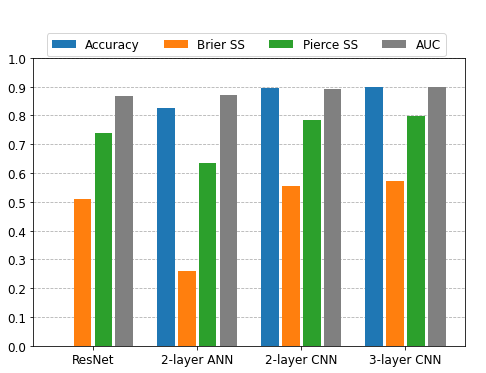

In [39]:
alldata=[
        [0, 0.824628, 0.893600, 0.897497],
        [0.510, 0.26, 0.555, 0.571],
        [0.739, 0.634, 0.783, 0.797],
        [0.869, 0.871, 0.892, 0.898]
        ]
X = np.arange(4)
Y = np.arange(0.0,1.1,0.1)
strY = ["%.1f" % Ys for Ys in Y]
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.set_xticks([0.3,1.3, 2.3, 3.3])
ax.set_xticklabels(["ResNet", "2-layer ANN","2-layer CNN","3-layer CNN"], fontsize=12)
ax.set_ylim(0,1)
ax.set_yticks(Y)
ax.set_yticklabels(strY, fontsize=12)
ax.bar(X + 0.0, alldata[0], width = 0.17, zorder=3)
ax.bar(X + 0.2, alldata[1], width = 0.17, zorder=3)
ax.bar(X + 0.4, alldata[2], width = 0.17, zorder=3)
ax.bar(X + 0.6, alldata[3], width = 0.17, color='grey', zorder=3)
fig.legend(("Accuracy","Brier SS","Pierce SS", "AUC"), loc='upper center', bbox_to_anchor=(0.57, 1.2), fontsize=12, ncol = 4)
ax.grid(axis='y', zorder=0, linestyle='--')

## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.